# Eigenvalue problem for the Schrodinger operator

First of all we include all the necessary libraries

In [1]:
import numpy as np
from scipy.sparse import diags
from scipy.linalg import eigh
from scipy.special import eval_hermite, factorial
from scipy.stats import norm

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from abc import ABC, abstractmethod

from wolframclient.language import wlexpr
from wolframclient.evaluation import WolframLanguageSession

In this notebook, we implement a modular framework for solving the time-evolution equation $\partial_t \psi = -H \psi$, where the Hamiltonian is given by $$H = -\sigma \Delta + W(x).$$ 
The design is based on a clear separation between the method used to compute the eigenfunctions of $H$ and the time-evolution solver that uses these eigenfunctions.

### Codes

The class *BaseOperatorApproximator* is an abstract base class that defines the interface and common properties (such as the spatial grid and the potential function $W(x)$ for constructing the operator $H$. 
It declares an abstract method `solve_eigen()` which returns the eigenvalues and eigenfunctions of $H$. 
This class forms the default structure for any method we choose to approximate the operator, ensuring that the downstream evolution code remains independent of the eigenfunction computation method.

In [2]:
class BaseOperatorApproximator(ABC):
    def __init__(self, L=10.0, N=256, sigma=1.0,
                 potential_func=None, potential_expr=None, options=None):
        """
        Parameters:
          L             : half-length of the domain (domain: [-L, L])
          N             : number of spatial grid points
          sigma         : parameter in H = -sigma * Δ + W(x)
          potential_func: callable returning W(x) for an array of x values.
          potential_expr: a string representing W(x) (e.g. for Wolfram Language).
          options       : additional options.
          
        At least one of potential_func or potential_expr must be provided.
        """
        self.L = L
        self.N = N
        self.sigma = sigma
        self.options = options if options is not None else {}
        self.x = np.linspace(-L, L, N)
        self.dx = self.x[1] - self.x[0]
        if potential_func is None and potential_expr is None:
            raise ValueError("Provide at least potential_func or potential_expr.")
        self.potential_func = potential_func
        self.potential_expr = potential_expr

    @abstractmethod
    def solve_eigen(self, num_eigen=10, derivative=False):
        """Compute the lowest num_eigen eigenpairs."""
        pass

This subclass of `BaseOperatorApproximator` leverages the Wolfram Engine through the Wolfram Client Library for Python to compute eigenfunctions using Mathematica’s `NDEigensystem` function. 
It opens a Wolfram Language session, sends the appropriate command, and samples the computed eigenfunctions on the numerical grid. 

In [3]:
class WolframNDEigensystemApproximator(BaseOperatorApproximator):
    def __init__(self, kernel_path, L=10.0, N=256, sigma=1.0,
                 potential_expr=None, potential_func=None, options=None):
        """
        Parameters:
          kernel_path   : path to the WolframKernel executable.
          potential_expr: a string representing W(x) in Wolfram Language.
          (potential_func is accepted for uniformity but not used here.)
        """
        super().__init__(L=L, N=N, sigma=sigma,
                         potential_func=potential_func, potential_expr=potential_expr,
                         options=options)
        self.kernel_path = kernel_path
        if self.potential_expr is None:
            raise ValueError("WolframNDEigensystemApproximator requires potential_expr.")

    def solve_eigen(self, num_eigen=10, derivative=False):
        
        session = WolframLanguageSession(kernel=self.kernel_path)
        MaxCellMeasure = self.options.get("MaxCellMeasure", 0.5)
        
        wolfram_script = f"""
        Module[{{eigenvalues, eigenfunctions, pts}},
          Clear[u];
          (* pts is a flat list of evaluation points *)
          pts = Subdivide[-{self.L+self.dx}, {self.L+self.dx}, {self.N} + 1];
          
          (* Compute eigenvalues and eigenfunctions *)
          {{eigenvalues, eigenfunctions}} = 
            NDEigensystem[
              {{-{self.sigma}*D[u[x], {{x, 2}}] + ({self.potential_expr})*u[x], u[-{self.L+self.dx}] == 0, u[{self.L+self.dx}] == 0}},
              u[x],
              {{x, -{self.L+self.dx}, {self.L+self.dx}}},
              {num_eigen},
              Method -> {{"Eigensystem" -> "Direct",
                          "PDEDiscretization" -> {{"FiniteElement", {{"MeshOptions" -> {{"MaxCellMeasure" -> {MaxCellMeasure}}}
                                                                       }}
                                                    }}
                        }}
            ];
        
          (* Evaluate each eigenfunction at the points in pts *)
          (* This produces a list of two lists, one per eigenfunction *)
        
          values = Table[N[eigenfunctions[[i]][x]], {{i, Length[eigenfunctions]}}, {{x, pts}}];

          (* Return both eigenvalues and the evaluated eigenfunction values *)
          {{eigenvalues, eigenfunctions, values}}
        ]
        """
        
        result = session.evaluate(wlexpr(wolfram_script))
        eigenvalues = np.array(result[0], dtype=float)
        eigfunc_matrix = np.array([[value.head for value in eig] for eig in result[2]]).T

        session.terminate()

        if derivative:
            eigfunc_diffs = (eigfunc_matrix[2:, :] - eigfunc_matrix[:-2, :]) / (2*self.dx)
            return eigenvalues, eigfunc_matrix[1:-1], eigfunc_diffs
        
        return eigenvalues, eigfunc_matrix[1:-1]

This subclass of `BaseOperatorApproximator` implements a finite-difference approach to discretize the operator $H$. 
It constructs a matrix representation of $H$ by approximating the Laplacian using centred finite differences and then computes the eigenpairs. 

In [4]:
class FiniteDifferenceApproximator(BaseOperatorApproximator):
    def build_operator(self):
        # This approximator relies on a callable potential.
        if self.potential_func is None:
            raise ValueError("FiniteDifferenceApproximator requires potential_func.")
        W = self.potential_func(self.x)
        main_diag = -2.0 * np.ones(self.N) / self.dx**2
        off_diag = np.ones(self.N - 1) / self.dx**2
        laplacian = diags([off_diag, main_diag, off_diag], offsets=[-1, 0, 1]).toarray()
        H = -self.sigma * laplacian + np.diag(W)
        return H

    def solve_eigen(self, num_eigen=10, derivative=False):
        H = self.build_operator()
        eigvals, eigvecs = eigh(H)
        return eigvals[:num_eigen], eigvecs[:, :num_eigen]

This class has the spectral method used to solve the time evolution problem $\partial_t \psi = -H \psi$. 
It takes an instance of a `BaseOperatorApproximator` and uses the provided eigenvalues and eigenfunctions to project an initial condition onto the eigenbasis. 
The evolution is then computed by evolving each mode independently with an exponential decay determined by its eigenvalue.

In [5]:
class SchrodingerSolver:
    def __init__(self, approximator, psi0, num_eigen=10):
        """
        Parameters:
          approximator: an instance of a subclass of BaseOperatorApproximator.
          psi0: initial condition. It should be either a callable (function of x) or an array of initial values f(x,0).
          num_eigen: number of eigenfunctions to use in the spectral expansion.
        """
        self.approximator = approximator
        self.x = approximator.x
        self.dx = approximator.dx
        self.eigvals, self.eigfuncs = self.approximator.solve_eigen(num_eigen)
        self.set_initial_condition(psi0)

    def set_initial_condition(self, f0):
        if callable(f0):
            f0_arr = f0(self.x)
        else:
            f0_arr = np.asarray(f0)
            if f0_arr.shape != self.x.shape:
                raise ValueError("The initial condition array must have the same shape as the spatial grid.")

        self.psi0 = f0_arr
        self.a0 = np.dot(np.conjugate(self.eigfuncs).T, f0_arr) * self.dx

    def evolve(self, t):
        """
        Returns the solution psi(x,t) at time t using the spectral expansion.
        """
        a_t = self.a0 * np.exp(-self.eigvals * t)
        psi_t = np.dot(self.eigfuncs, a_t)
        return psi_t

### Experiments with Schordinger Operator

Let's try it out with simplest interesting example: $W(x) = \frac{1}{2} x^2$

In [6]:
# Finite Differences
# approximator = FiniteDifferenceApproximator(potential_func=lambda x:0.5*x**2, L=10.0, N=256, sigma=1.0)
    
# WolframNDEigensystem
kernel_path = '/Applications/Wolfram.app/Contents/MacOS/WolframKernel'
approximator = WolframNDEigensystemApproximator(kernel_path, potential_expr="0.5*x^2", 
                                                L=10.0, N=200, sigma=1.0, options={"MaxCellMeasure": 0.5})

def initial_condition(x):
    return np.exp(-x**2)
    
solver = SchrodingerSolver(approximator, psi0=initial_condition, num_eigen=20)

#solver.plot_solution(0)
#solver.plot_solution(2)

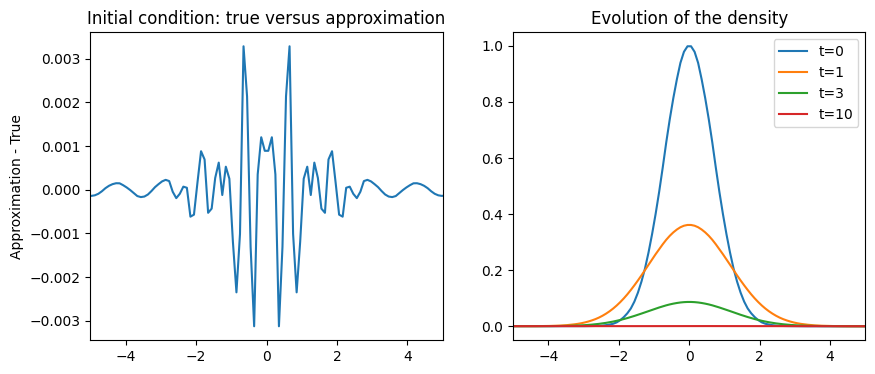

In [7]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].set_title("Initial condition: true versus approximation")
ax[0].set_ylabel("Approximation - True")
ax[0].plot(solver.x, solver.evolve(t=0)-initial_condition(solver.x))
ax[0].set_xlim((-5,5))

ax[1].set_title("Evolution of the density")
ax[1].plot(solver.x, solver.evolve(t=0), label="t=0")
ax[1].plot(solver.x, solver.evolve(t=1), label="t=1")
ax[1].plot(solver.x, solver.evolve(t=3), label="t=3")
ax[1].plot(solver.x, solver.evolve(t=10), label="t=10")
ax[1].legend()
ax[1].set_xlim((-5,5))

plt.show()

Are the eigenfunctions being well-approximated? Let us compare with the true ones.

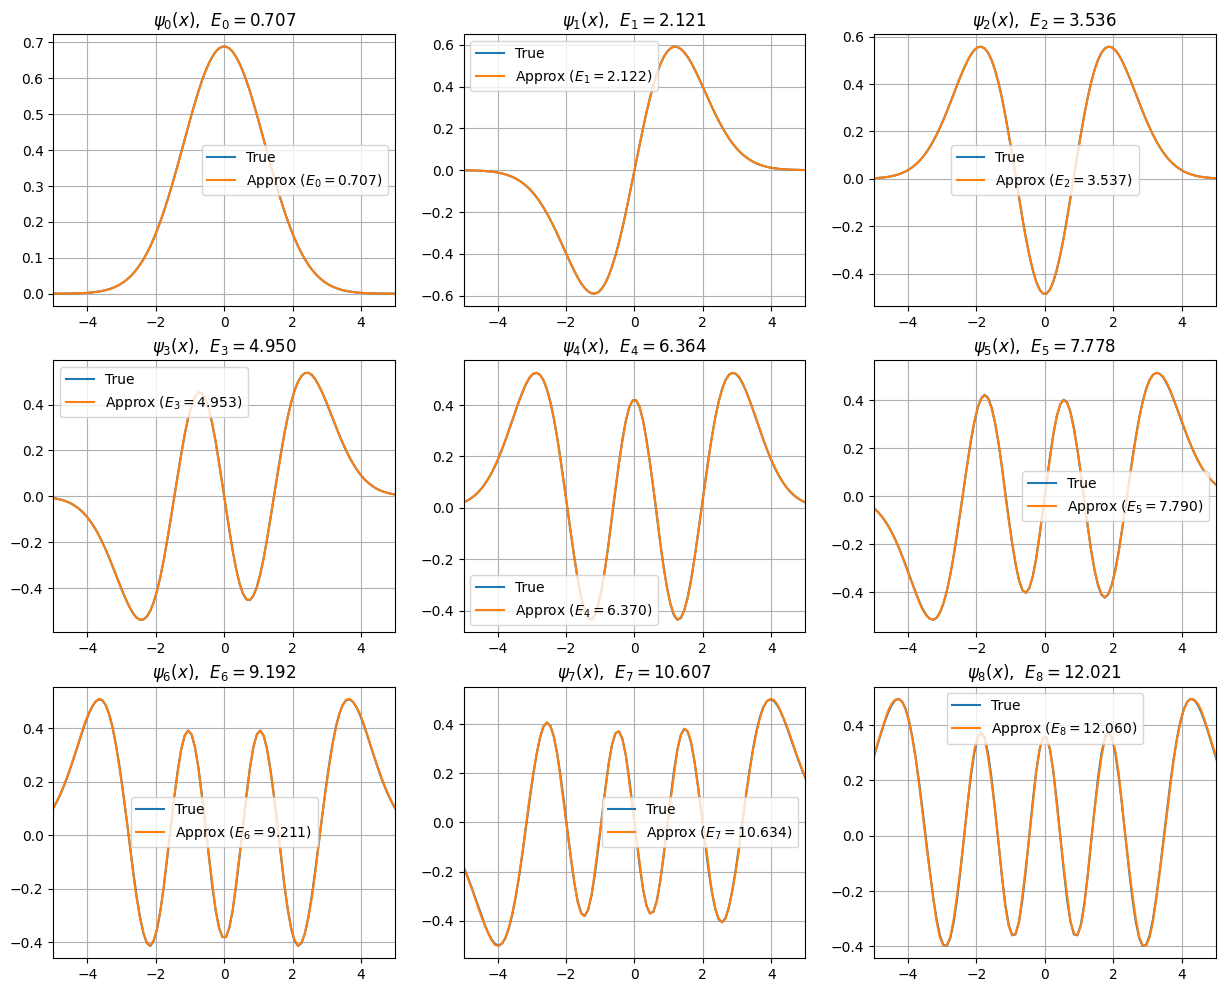

In [8]:
def eigenfunction(x, n, sigma=1.0):
    alpha = (1/(2*sigma))**0.25
    N_n = np.sqrt(alpha / (np.sqrt(np.pi) * (2**n) * factorial(n)))
    return N_n * np.exp(-0.5 * (alpha * x)**2) * eval_hermite(n, alpha * x)

def eigenvalue(n, sigma=1.0):
    return np.sqrt(sigma/2) * (2*n + 1)

fig, ax = plt.subplots(3,3,figsize=(15,12))
for i in range(3):
    for j in range(3):
        y = eigenfunction(solver.x, 3*i + j)
        E_n = eigenvalue(3*i + j)
        ax[i,j].plot(solver.x, y, label="True")
        ax[i,j].set_title(r'$\psi_{%d}(x)$,  $E_{%d}=%.3f$' % (3*i + j, 3*i + j, E_n))
        ax[i,j].grid(True)

        ax[i,j].plot(solver.x, solver.eigfuncs[:, 3*i + j], label=r"Approx ($E_{} = {:.3f}$)".format(3*i + j, solver.eigvals[3*i + j]))

        ax[i,j].legend()
        ax[i,j].set_xlim((-5,5))
        
plt.show()

### Relation to the FPE

Here we assume  
$$W(x) = \frac{1}{4\sigma} \|\nabla V(x)\|^2 - \frac{1}{2} \Delta V(x).$$

The simplest case, let $V(x) = \frac{1}{2}x^2$. In this case, $W(x) =  \frac{1}{4\sigma} x^2 - \frac{1}{2}.$ Then, after solving the Schrodinger equation, we go back to the right place of the transformation.

In [9]:
class FokkerPlanckSolver(SchrodingerSolver):
    
    def __init__(self, potential, approximator, rho0, num_eigen=10):
        """
        Parameters:
          potential: function of x V. 
                     Notice that the appromimator should be computed accordanly using W(x) = 1/(4sigma) |V'(x)|^2 - 1/2 V''(x)
          approximator: an instance of a subclass of BaseOperatorApproximator.
          rho0: initial condition. It should be either a callable (function of x).
          num_eigen: number of eigenfunctions to use in the spectral expansion.
        """
        eval_points = np.linspace(-10*approximator.L, 10*approximator.L, int(10000*approximator.L))
        constant = np.trapezoid(np.exp(-potential(eval_points) / approximator.sigma), eval_points) 
        self.rho_infinity = lambda x: np.exp(-potential(x) / approximator.sigma) / constant
        psi0 = lambda x: rho0(x) / np.sqrt(self.rho_infinity(x))

        super().__init__(approximator=approximator, psi0=psi0, num_eigen=num_eigen)

    def solve(self, t):
        """
        Returns the solution rho(x,t) at time t using the spectral expansion.
        """
        return self.evolve(t) * np.sqrt(self.rho_infinity(self.x))

In [10]:
kernel_path = '/Applications/Wolfram.app/Contents/MacOS/WolframKernel'
approximator = WolframNDEigensystemApproximator(kernel_path, potential_expr="0.25*x^2-0.5", 
                                                L=5.0, N=5000, sigma=1.0, options={"MaxCellMeasure": 0.1})

initial_condition = lambda x: norm.pdf(x, scale=0.5)
solver = FokkerPlanckSolver(potential=lambda x: 0.5*x*x,
                            approximator=approximator, rho0=initial_condition, num_eigen=50)

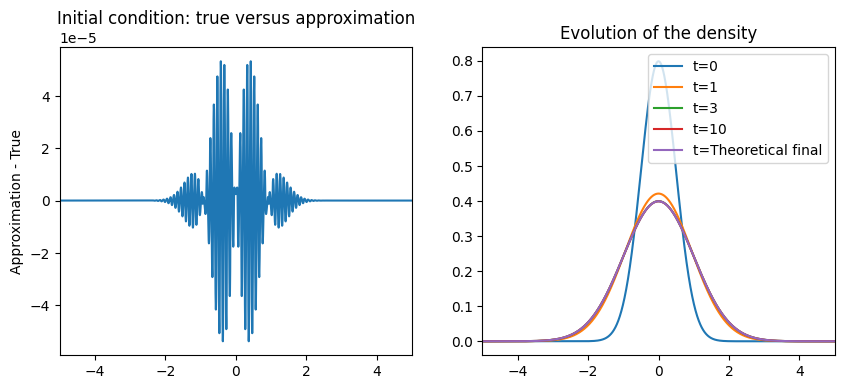

In [11]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].set_title("Initial condition: true versus approximation")
ax[0].set_ylabel("Approximation - True")
ax[0].plot(solver.x, solver.solve(t=0)-initial_condition(solver.x))
ax[0].set_xlim((-5,5))

ax[1].set_title("Evolution of the density")
ax[1].plot(solver.x, solver.solve(t=0), label="t=0")
ax[1].plot(solver.x, solver.solve(t=1), label="t=1")
ax[1].plot(solver.x, solver.solve(t=3), label="t=3")
ax[1].plot(solver.x, solver.solve(t=10), label="t=10")
ax[1].plot(solver.x, norm.pdf(solver.x, scale=1), label="t=Theoretical final")
ax[1].legend()
ax[1].set_xlim((-5,5))

plt.show()